# Disclaimer: 
This notebook is based on Hands-On Image Processing with Python by Sandipan Dey 

# Path to images

In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('../'))

from scripts.config import path_to_images, path_to_output

In [2]:
PATH = path_to_images + "/general/"

In [4]:
#  create dates and output directory
import datetime

class DateTime:
    def __init__(self):
        pass

    @staticmethod
    def today_time_now():
        today = datetime.date.today()
        date_today = today.strftime("%Y_%m_%d")
        now = datetime.datetime.now()
        date_now = now.strftime("%Y_%m_%d_%H_%M_%S")    

        return date_today, date_now
    
def create_dir(path)->None:   
    """ Creats a directory.

    Parameters
    ----------
    date_today : str
        Date today.
    date_now : str
        Date now.
    """
    # Create the directory 
    path_dir_w_time = path
    try:
        os.makedirs(path_dir_w_time)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    
#  create dates and output directory
dt = DateTime()
date_today, date_now = dt.today_time_now()

output_path_dir_w_time = (path_to_output + "/" + date_today + "/" + date_now)
create_dir(output_path_dir_w_time)

In [5]:
%matplotlib inline
import numpy as np
from skimage import data, img_as_float, img_as_ubyte, exposure, io, color
from skimage.io import imread
from skimage.exposure import cumulative_distribution
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
#from skimage.measure import compare_psnr
from skimage.util import random_noise
from skimage.color import rgb2gray
from PIL import Image, ImageEnhance, ImageFilter
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import cv2
import PIL.ImageStat as stat


In [6]:
def plot_image(image, title=''):
    plt.title(title, size=20), plt.imshow(image)
    plt.axis('off') # comment this line if you want axis ticks
    
def plot_hist(r, g, b, title=''):
    #r, g, b = img_as_ubyte(r), img_as_ubyte(g), img_as_ubyte(b)
    plt.hist(r.ravel(),100,alpha = 0.5, lw=3, color='r', label='r')
    plt.hist(g.ravel(),100,alpha = 0.5, lw=3, color='g', label='g')
    plt.hist(b.ravel(),100,alpha = 0.5, lw=3, color='b', label='b')
    plt.xlabel('pixel value', size=20), plt.ylabel('frequency', size=20)
    plt.title(title, size=20)
    
def print_array_statistics(arr):
    """
    Prints statistics of a given array or image.
    
    Parameters:
        arr (numpy.ndarray): The input array or image.
    """
    # Check if the input is a NumPy array
    if not isinstance(arr, np.ndarray):
        print("The input is not a NumPy array.")
        return
    
    # Determine if the array has 3 channels (assuming the last dimension refers to channels)
    if len(arr.shape) == 3 and arr.shape[2] == 3:
        channels = ['Red', 'Green', 'Blue']
        for idx, channel in enumerate(channels):
            print(f"Statistics for {channel} channel:")
            print_channel_statistics(arr[:, :, idx])
            print("\n")
    else:
        print("Array Statistics:")
        print_channel_statistics(arr)
        
def print_channel_statistics(channel):
    """Prints statistics for a given channel or grayscale image."""
    min_val = np.min(channel)
    max_val = np.max(channel)
    mean_val = np.mean(channel)
    std_dev = np.std(channel)
    shape = channel.shape
    dtype = channel.dtype
    
    # Print statistics
    print(f"  Shape: {shape}")
    print(f"  Data Type: {dtype}")
    print(f"  Min Value: {min_val}")
    print(f"  Max Value: {max_val}")
    print(f"  Mean: {mean_val}")
    print(f"  Standard Deviation: {std_dev}") 

# Read image Check RGB histogram

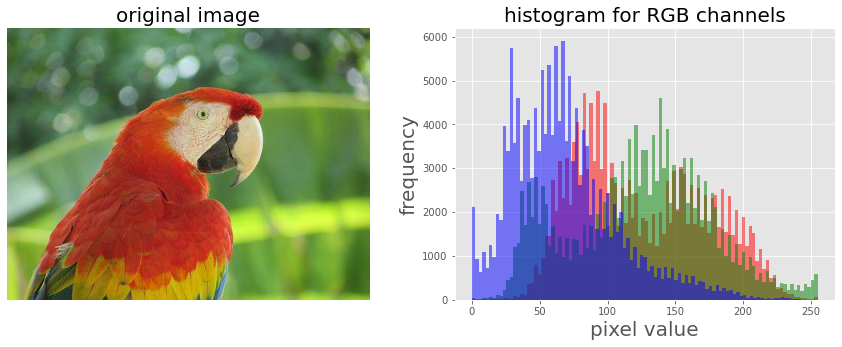

In [7]:
image_bgr = cv2.imread(PATH + "parrot.png", cv2.IMREAD_UNCHANGED)
# Convert BGR to RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#img_scaled = cv2.normalize(img, dst=None, alpha=0, beta=256, norm_type=cv2.NORM_MINMAX)

im_r, im_g, im_b = cv2.split(image_rgb)
plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.subplot(121), plot_image(image_rgb, 'original image')
plt.subplot(122), plot_hist(im_r, im_g, im_b,'histogram for RGB channels')
plt.show()

In [8]:
# print image statistics
print_array_statistics(image_rgb)

Statistics for Red channel:
  Shape: (340, 453)
  Data Type: uint8
  Min Value: 0
  Max Value: 255
  Mean: 125.41716010907675
  Standard Deviation: 47.763871467000165


Statistics for Green channel:
  Shape: (340, 453)
  Data Type: uint8
  Min Value: 0
  Max Value: 255
  Mean: 124.4158940397351
  Standard Deviation: 51.19863631276634


Statistics for Blue channel:
  Shape: (340, 453)
  Data Type: uint8
  Min Value: 0
  Max Value: 253
  Mean: 68.46314764316323
  Standard Deviation: 39.29534599039047




In [9]:
# Normalize image
img_norm = image_rgb.astype(np.float32) / 255.0
print_array_statistics(img_norm)

Statistics for Red channel:
  Shape: (340, 453)
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean: 0.49183201789855957
  Standard Deviation: 0.18730930984020233


Statistics for Green channel:
  Shape: (340, 453)
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean: 0.48790547251701355
  Standard Deviation: 0.20077897608280182


Statistics for Blue channel:
  Shape: (340, 453)
  Data Type: float32
  Min Value: 0.0
  Max Value: 0.9921568632125854
  Mean: 0.2684829831123352
  Standard Deviation: 0.15409940481185913




### Import libraries

In [10]:
%matplotlib inline
import skimage
print(skimage.__version__)
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage import color, viewer, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl
from skimage.util import invert, random_noise, montage
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from scipy.ndimage import affine_transform, zoom
from scipy import misc

0.19.3


/home/ads/jm095624/anaconda3/envs/env-imgprocess/lib/python3.10/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


### Reading, saving, and displaying an image using PIL

In [11]:
im = Image.open(PATH + "parrot.png") # read the image, provide the correct path
print(im.width, im.height, im.mode, im.format, type(im))
# 453 340 RGB PNG <class 'PIL.PngImagePlugin.PngImageFile'>
im.show() # display the image

453 340 RGB PNG <class 'PIL.PngImagePlugin.PngImageFile'>


This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



In [13]:
im_g = im.convert('L') # convert the RGB color image to a grayscale image
im_g.save(output_path_dir_w_time + '/parrot_gray.png') # save the image to disk
Image.open(output_path_dir_w_time + "/parrot_gray.png").show() # read the grayscale image from disk and show

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Reading, saving, and displaying an image using Matplotlib

(960, 1280, 4) float32 <class 'numpy.ndarray'>


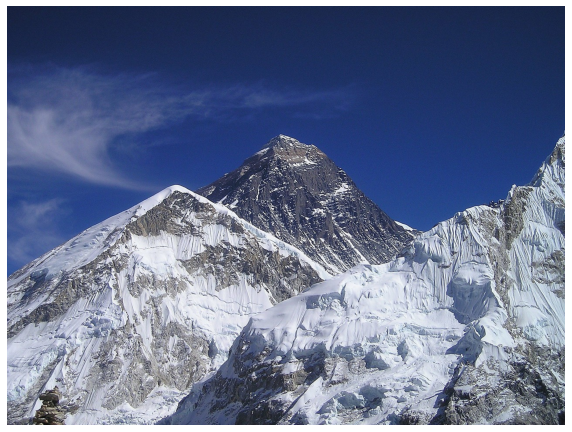

In [14]:
im = mpimg.imread(PATH + "hill.png") # read the image from disk as a numpy ndarray
print(im.shape, im.dtype, type(im)) # this image contains an α channel, hence num_channels= 4
# (960, 1280, 4) float32 <class 'numpy.ndarray'>
plt.figure(figsize=(10,10))
plt.imshow(im) # display the image
plt.axis('off')
plt.show()

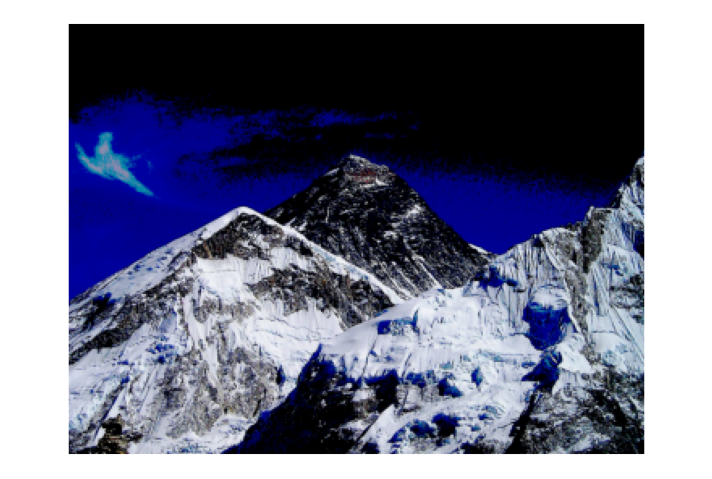

In [15]:
im1 = im
im1[im1 < 0.5] = 0 # make the image look darker
plt.imshow(im1)
plt.axis('off')
plt.tight_layout()
plt.savefig(output_path_dir_w_time + "/hill_dark.png") # save the dark image
plt.close()
im = mpimg.imread(output_path_dir_w_time + "/hill_dark.png") # read the dark image
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis('off') # no axis ticks
plt.tight_layout()
plt.show()

### Interpolating while displaying with matplotlib imshow

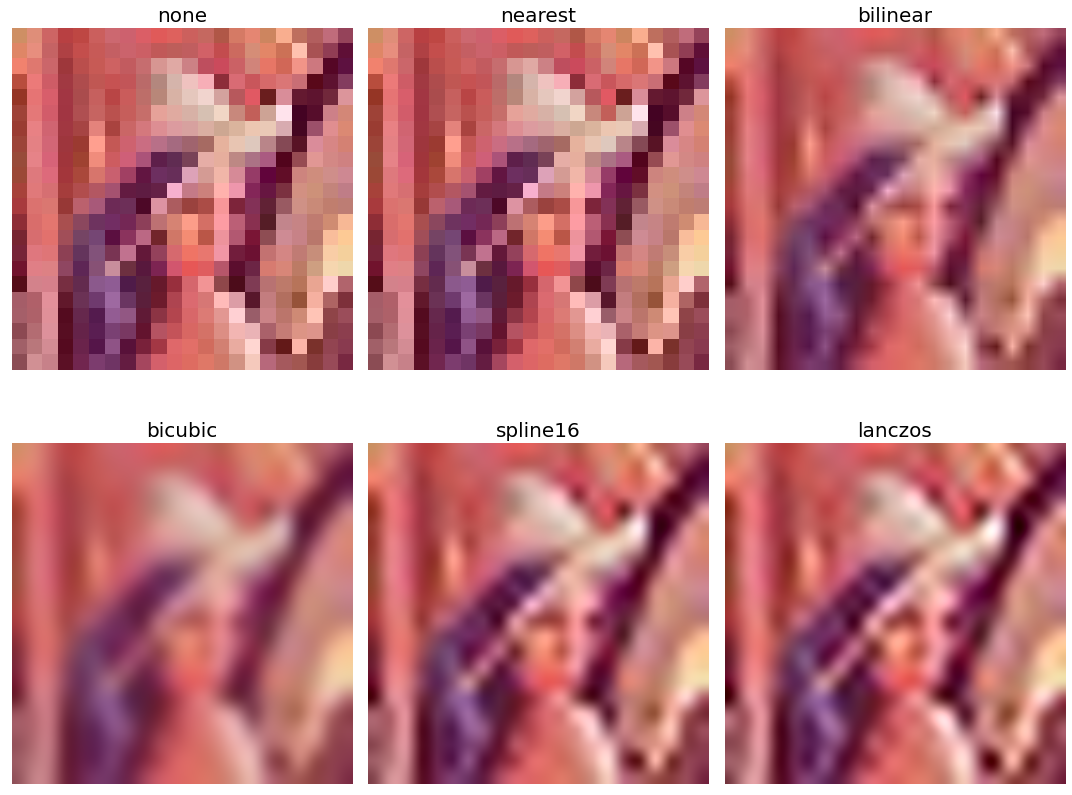

In [16]:
im = mpimg.imread(PATH + "lena_small.jpg") # read the image from disk as a numpy ndarray
methods = ['none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'lanczos']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for ax, interp_method in zip(axes.flat, methods):
    ax.imshow(im, interpolation=interp_method)
    ax.set_title(str(interp_method), size=20)
plt.tight_layout()
plt.show()

### Converting from one file format to another

In [17]:
# e.g. from png to jpg
im = Image.open(PATH + "/parrot.png")
print(im.mode)
im.save(output_path_dir_w_time + "/parrot.jpg")

RGB


In [18]:
# show
Image.open(output_path_dir_w_time + "/parrot.jpg").show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



In [19]:
im = Image.open(PATH + "hill.png")
print(im.mode)
# RGBA
im.convert('RGB').save(output_path_dir_w_time + "/hill.jpg") # first convert to RGB mode

RGBA


In [20]:
#show
Image.open(PATH + "hill.png").show()
Image.open(output_path_dir_w_time + "/hill.jpg").show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



In [21]:
!identify ../output/hill.jpg

identify: /home/ads/jm095624/anaconda3/envs/env-imgprocess/lib/python3.10/site-packages/cv2/../../../../lib/./libuuid.so.1: no version information available (required by /lib64/libSM.so.6)
identify: unable to open image `../output/hill.jpg': No such file or directory @ error/blob.c/OpenBlob/2882.


In [22]:
!identify /home/meshreki/XNAS/CSE/CSE-Research/LAB_share/2023_computational_imaging_datasets/general/hill.png

identify: /home/ads/jm095624/anaconda3/envs/env-imgprocess/lib/python3.10/site-packages/cv2/../../../../lib/./libuuid.so.1: no version information available (required by /lib64/libSM.so.6)
identify: unable to open image `/home/meshreki/XNAS/CSE/CSE-Research/LAB_share/2023_computational_imaging_datasets/general/hill.png': No such file or directory @ error/blob.c/OpenBlob/2882.


### Converting from one image mode into another

(340, 453)


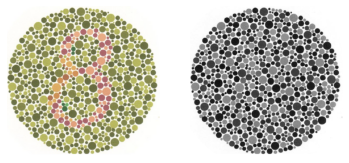

In [23]:
# e.g. color to gray
im = imread(PATH + "/parrot.png", as_gray=True)
print(im.shape)
im = imread(PATH + "/Ishihara.png")
im_g = color.rgb2gray(im)
plt.subplot(121), plt.imshow(im, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.imshow(im_g, cmap='gray'), plt.axis('off')
plt.show()

### Converting from one color space into another

<Figure size 432x288 with 0 Axes>

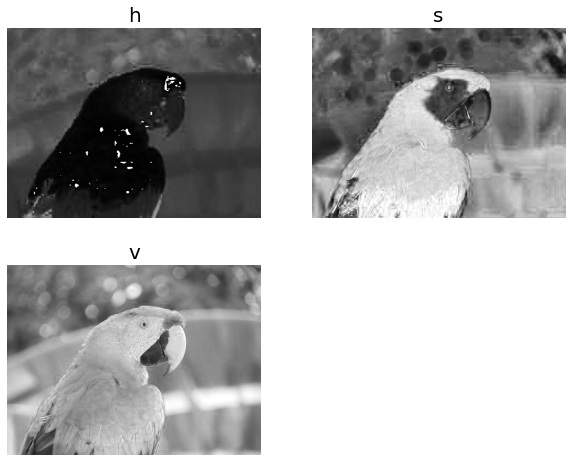

In [24]:
im = imread(PATH + "parrot.png")
im_hsv = color.rgb2hsv(im)
plt.gray()
plt.figure(figsize=(10,8))
plt.subplot(221), plt.imshow(im_hsv[...,0]), plt.title('h', size=20),
plt.axis('off')
plt.subplot(222), plt.imshow(im_hsv[...,1]), plt.title('s', size=20),
plt.axis('off')
plt.subplot(223), plt.imshow(im_hsv[...,2]), plt.title('v', size=20),
plt.axis('off')
plt.subplot(224), plt.axis('off')
plt.show()

### Converting image data structures

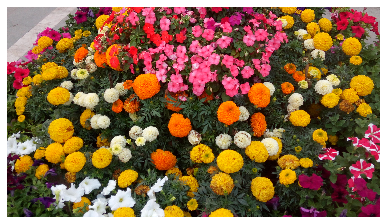

((-0.5, 4095.5, 2303.5, -0.5), None)

In [25]:
# e.g. to numpy arrays
im = Image.open(PATH + 'flowers.png') # read image into an Image object with PIL
im = np.array(im) # create a numpy ndarray from the Image object
imshow(im) # use skimage imshow to display the image
plt.axis('off'), show()

In [26]:
im = imread(PATH + 'flowers.png') # read image into numpy ndarray with skimage
im = Image.fromarray(im) # create a PIL Image object from the numpy ndarray
im.show() # display the image with PIL Image.show() method

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Image manipulations with numpy array slicing

In [29]:
lena = mpimg.imread(PATH + "lena.jpg").copy() # read the image from disk as a numpy ndarray
print(lena[0, 40])
# print(lena[10:13, 20:23,0:1]) # slicing
lx, ly, _ = lena.shape
X, Y = np.ogrid[0:lx, 0:ly]
mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4### Image manipulations with PIL

im = Image.open(PATH + "/parrot.png") # open the image, provide the correct path
print(im.width, im.height, im.mode, im.format) # print image size, mode and format

### Cropping an image

im_c = im.crop((175,75,320,200)) # crop the rectangle given by (left, top, right, bottom) from the image
im_c.show()

### Resizing an image

im = Image.open(PATH + "/clock.jpg")
print(im.width, im.height)
im.show()

im_large = im.resize((im.width*5, im.height*5), Image.BILINEAR) # bi-linear interpolation
im_large.show()

im = Image.open(PATH + "/victoria_memorial.png")
print(im.width, im.height)
im.show()

im_small = im.resize((im.width//5, im.height//5), Image.ANTIALIAS)
im_small.show()

### Negating an image

im = Image.open(PATH + "/parrot.png")
im_t = im.point(lambda x: 255 - x)
im_t.show()

### Converting an image into grayscale

im_g = im.convert('L') # convert the RGB color image to a grayscale image

### Log transformation
#### maps a narrow range of low intensity values in the input into a wider range of output levels.

im_g.point(lambda x: 255*np.log(1+x/255)).show()

### Power-law transformation
#### $s = c r^\gamma$

im_g.point(lambda x: 255*(x/255)**0.6).show()

### Reflecting an image

im.transpose(Image.FLIP_LEFT_RIGHT).show() # reflect about the vertical axis

### Rotating an image

im_45 = im.rotate(45) # rotate the image by 45 degrees
im_45.show() # show the rotated image

### Applying an Affine transformation on an image

im = Image.open(PATH + "/parrot.png")
im.transform((int(1.4*im.width), im.height), Image.AFFINE,
data=(1,-0.5,0,0,1,0)).show() # shear

### Perspective transformation

params = [1, 0.1, 0, -0.1, 0.5, 0, -0.005, -0.001]
im1 = im.transform((im.width//3, im.height), Image.PERSPECTIVE, params,
Image.BICUBIC)
im1.show()

### Salt and Pepper noise -- Changing pixel values of an image

# choose 5000 random locations inside image
im1 = im.copy() # keep the original image, create a copy
n = 5000
x, y = np.random.randint(0, im.width, n), np.random.randint(0, im.height,n)
for (x,y) in zip(x,y):
    im1.putpixel((x, y), ((0,0,0) if np.random.rand() < 0.5 else (255,255,255))) # salt-and-pepper noise
im1.show()

### Drawing on an image

im = Image.open(PATH + "/parrot.png")
draw = ImageDraw.Draw(im)
draw.ellipse((125, 125, 200, 250), fill=(255,255,255,128))
del draw
im.show()

### Drawing text on an image

im = Image.open(PATH + "/parrot.png")
draw = ImageDraw.Draw(im)
font = ImageFont.truetype("arial.ttf", 23) # use a truetype font
draw.text((10, 5), "Welcome to image processing with python", font=font)
del draw
im.show()

### Creating a thumbnail

im = Image.open(PATH + "/parrot.png")
im_thumbnail = im.copy() # need to copy the original image first
im_thumbnail.thumbnail((100,100)) # now paste the thumbnail on the image
im.paste(im_thumbnail, (10,10))
im.save(output_path_dir_w_time + "/parrot_thumb.jpg")
im.show()

### Computing the basic statistics of an image

s = stat.Stat(im)
print("""
... * Min/max values for each channel in the image:
...     {.extrema}
...
... * Total number of pixels for each channel in the image:
...     {.count}
...
... * Sum of all pixels for each channel in the image:
...     {.sum}
...
... * Squared sum of all pixels for each channel in the image:
...     {.sum2}
...
... * Average (arithmetic mean) pixel level for each channel in the image:
...     {.mean}
...
... * Median pixel level for each channel in the image:
...     {.median}
...
... * RMS (root-mean-square) for each channel in the image:
...     {.rms}
...
... * Variance for each channel in the image:
...     {.var}
...
... * Standard deviation for each channel in the image:
...     {.stddev}
... """.format(*((s, ) * 9)))

### Plotting the histograms of pixel values for the RGB channels of an image

pl = im.histogram()
plt.bar(range(256), pl[:256], color='r', alpha=0.5)
plt.bar(range(256), pl[256:2*256], color='g', alpha=0.4)
plt.bar(range(256), pl[2*256:], color='b', alpha=0.3)
plt.show()

### Separating the RGB channels of an image

im = Image.open(PATH + "/parrot.png")
ch_r, ch_g, ch_b = im.split() # split the RGB image into 3 channels: R, G and B
# we shall use matplotlib to display the channels
plt.figure(figsize=(18,6))
plt.subplot(1,3,1); plt.imshow(ch_r, cmap=plt.cm.Reds); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(ch_g, cmap=plt.cm.Greens); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(ch_b, cmap=plt.cm.Blues); plt.axis('off')
plt.tight_layout()
plt.show() # show the R, G, B channels

### Combining multiple channels of an image

im = Image.merge('RGB', (ch_b, ch_g, ch_r)) # swap the red and blue channels obtained last time with split()
im.show()

### α-blending two images

im1 = Image.open(PATH + "/parrot.png")
im2 = Image.open(PATH + "/hill.png")
im1 = im1.convert('RGBA') # two images have different modes, must be converted to the same mode
im2 = im2.resize((im1.width, im1.height), Image.BILINEAR) # two images have different sizes, must be converted to the same size
im = Image.blend(im1, im2, alpha=0.5).show()

### Superimposing two images

im1 = Image.open(PATH + "/parrot.png")
im2 = Image.open(PATH + "/hill.png").convert('RGB').resize((im1.width, im1.height))
multiply(im1, im2).show()

### Adding two images

add(im1, im2).show()

### Computing the difference between two images

from PIL.ImageChops import subtract, multiply, screen, difference, add
im1 = Image.open(PATH + "/images/goal1.png") # load two consecutive frame images from the video
im2 = Image.open(PATH + "/images/goal2.png")
im = difference(im1, im2)
plt.figure(figsize=(20,25))
im.save(output_path_dir_w_time + "/goal_diff.png")
plt.subplot(311)
plt.imshow(im1)
plt.axis('off')
plt.subplot(312)
plt.imshow(im2)
plt.axis('off')
plt.subplot(313)
plt.imshow(im), plt.axis('off')
plt.show()
lena[mask,:] = 0 # masks
plt.figure(figsize=(10,10))
plt.imshow(lena), plt.axis('off'), plt.show()

[180  76  83]
453 340 RGB PNG
107 105
720 540


/tmp/ipykernel_16238/3170885312.py:22: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  im_large = im.resize((im.width*5, im.height*5), Image.BILINEAR) # bi-linear interpolation
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.

/tmp/ipykernel_16238/3170885312.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im_small = im.resize((im.width//5, im.height//5), Image.ANTIALIAS)
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.

/tmp/ipykernel_16238/3170885312.py:54: DeprecationWarning: F

OSError: cannot open resource

### Image manipulations with PIL

In [30]:
im = Image.open(PATH + "parrot.png") # open the image, provide the correct path
print(im.width, im.height, im.mode, im.format) # print image size, mode and format

453 340 RGB PNG


### Cropping an image

In [31]:
im_c = im.crop((175,75,320,200)) # crop the rectangle given by (left, top, right, bottom) from the image
im_c.show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Resizing an image

In [32]:
im = Image.open(PATH + "clock.jpg")
print(im.width, im.height)
im.show()

107 105


This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



In [33]:
im_large = im.resize((im.width*5, im.height*5), Image.BILINEAR) # bi-linear interpolation
im_large.show()

/tmp/ipykernel_16238/1905688226.py:1: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  im_large = im.resize((im.width*5, im.height*5), Image.BILINEAR) # bi-linear interpolation
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



In [34]:
im = Image.open(PATH + "victoria_memorial.png")
print(im.width, im.height)
im.show()

720 540


This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



In [35]:
im_small = im.resize((im.width//5, im.height//5), Image.ANTIALIAS)
im_small.show()

/tmp/ipykernel_16238/444509131.py:1: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im_small = im.resize((im.width//5, im.height//5), Image.ANTIALIAS)
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Negating an image

In [36]:
im = Image.open(PATH + "parrot.png")
im_t = im.point(lambda x: 255 - x)
im_t.show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Converting an image into grayscale

In [37]:
im_g = im.convert('L') # convert the RGB color image to a grayscale image
im_g.show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Log transformation
#### maps a narrow range of low intensity values in the input into a wider range of output levels.

In [38]:
im_g.point(lambda x: 255*np.log(1+x/255)).show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Power-law transformation
#### $s = c r^\gamma$

In [39]:
im_g.point(lambda x: 255*(x/255)**0.6).show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Reflecting an image

In [40]:
im.transpose(Image.FLIP_LEFT_RIGHT).show() # reflect about the vertical axis

/tmp/ipykernel_16238/2648353480.py:1: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  im.transpose(Image.FLIP_LEFT_RIGHT).show() # reflect about the vertical axis
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Rotating an image

In [41]:
im_45 = im.rotate(45) # rotate the image by 45 degrees
im_45.show() # show the rotated image

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Applying an Affine transformation on an image

In [42]:
im = Image.open(PATH + "parrot.png")
im.transform((int(1.4*im.width), im.height), Image.AFFINE,
data=(1,-0.5,0,0,1,0)).show() # shear

/tmp/ipykernel_16238/2095908534.py:2: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  im.transform((int(1.4*im.width), im.height), Image.AFFINE,
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Perspective transformation

In [43]:
params = [1, 0.1, 0, -0.1, 0.5, 0, -0.005, -0.001]
im1 = im.transform((im.width//3, im.height), Image.PERSPECTIVE, params,
Image.BICUBIC)
im1.show()

/tmp/ipykernel_16238/1768883284.py:2: DeprecationWarning: PERSPECTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.PERSPECTIVE instead.
  im1 = im.transform((im.width//3, im.height), Image.PERSPECTIVE, params,
/tmp/ipykernel_16238/1768883284.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Salt and Pepper noise -- Changing pixel values of an image

In [44]:
# choose 5000 random locations inside image
im1 = im.copy() # keep the original image, create a copy
n = 5000
x, y = np.random.randint(0, im.width, n), np.random.randint(0, im.height,n)
for (x,y) in zip(x,y):
    im1.putpixel((x, y), ((0,0,0) if np.random.rand() < 0.5 else (255,255,255))) # salt-and-pepper noise
im1.show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Drawing on an image

In [45]:
im = Image.open(PATH + "parrot.png")
draw = ImageDraw.Draw(im)
draw.ellipse((125, 125, 200, 250), fill=(255,255,255,128))
del draw
im.show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Creating a thumbnail

In [48]:
im = Image.open(PATH + "parrot.png")
im_thumbnail = im.copy() # need to copy the original image first
im_thumbnail.thumbnail((100,100)) # now paste the thumbnail on the image
im.paste(im_thumbnail, (10,10))
im.save(output_path_dir_w_time + "/parrot_thumb.jpg")
im.show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Computing the basic statistics of an image

In [49]:
s = stat.Stat(im)
print("""
... * Min/max values for each channel in the image:
...     {.extrema}
...
... * Total number of pixels for each channel in the image:
...     {.count}
...
... * Sum of all pixels for each channel in the image:
...     {.sum}
...
... * Squared sum of all pixels for each channel in the image:
...     {.sum2}
...
... * Average (arithmetic mean) pixel level for each channel in the image:
...     {.mean}
...
... * Median pixel level for each channel in the image:
...     {.median}
...
... * RMS (root-mean-square) for each channel in the image:
...     {.rms}
...
... * Variance for each channel in the image:
...     {.var}
...
... * Standard deviation for each channel in the image:
...     {.stddev}
... """.format(*((s, ) * 9)))


... * Min/max values for each channel in the image:
...     [(0, 255), (0, 255), (0, 253)]
...
... * Total number of pixels for each channel in the image:
...     [154020, 154020, 154020]
...
... * Sum of all pixels for each channel in the image:
...     [19657381.0, 19233758.0, 10458216.0]
...
... * Squared sum of all pixels for each channel in the image:
...     [2859053405.0, 2822316846.0, 955454648.0]
...
... * Average (arithmetic mean) pixel level for each channel in the image:
...     [127.62875600571354, 124.87831450460979, 67.90167510712894]
...
... * Median pixel level for each channel in the image:
...     [121, 130, 62]
...
... * RMS (root-mean-square) for each channel in the image:
...     [136.24562777634506, 135.36747386330458, 78.761953497801]
...
... * Variance for each channel in the image:
...     [2273.771728604407, 2729.7595466202133, 1592.8078364356727]
...
... * Standard deviation for each channel in the image:
...     [47.684082549676965, 52.24710084416372, 39.9

### Plotting the histograms of pixel values for the RGB channels of an image

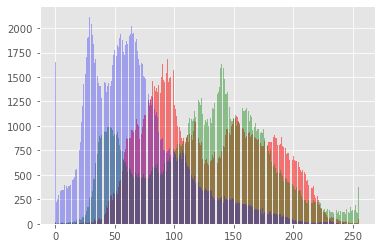

In [50]:
pl = im.histogram()
plt.bar(range(256), pl[:256], color='r', alpha=0.5)
plt.bar(range(256), pl[256:2*256], color='g', alpha=0.4)
plt.bar(range(256), pl[2*256:], color='b', alpha=0.3)
plt.show()

### Separating the RGB channels of an image

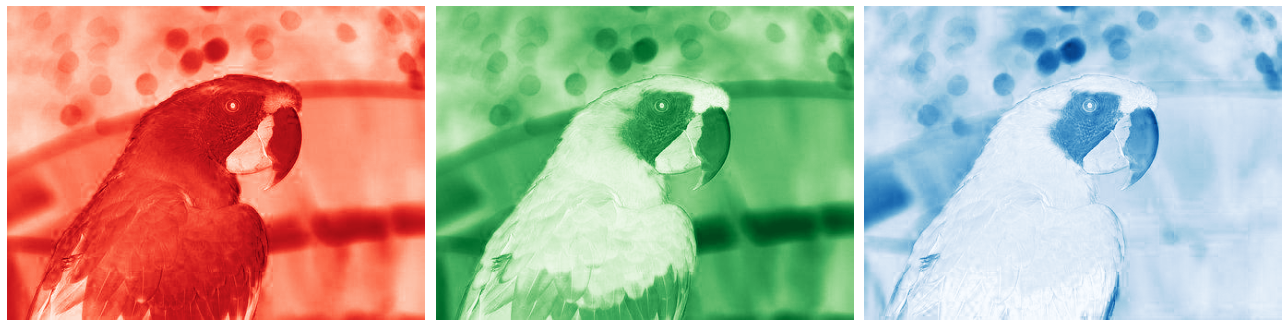

In [51]:
im = Image.open(PATH + "parrot.png")
ch_r, ch_g, ch_b = im.split() # split the RGB image into 3 channels: R, G and B
# we shall use matplotlib to display the channels
plt.figure(figsize=(18,6))
plt.subplot(1,3,1); plt.imshow(ch_r, cmap=plt.cm.Reds); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(ch_g, cmap=plt.cm.Greens); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(ch_b, cmap=plt.cm.Blues); plt.axis('off')
plt.tight_layout()
plt.show() # show the R, G, B channels

### Combining multiple channels of an image

In [52]:
im = Image.merge('RGB', (ch_b, ch_g, ch_r)) # swap the red and blue channels obtained last time with split()
im.show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### α-blending two images

In [53]:
im1 = Image.open(PATH +"parrot.png")
im2 = Image.open(PATH + "hill.png")
im1 = im1.convert('RGBA') # two images have different modes, must be converted to the same mode
im2 = im2.resize((im1.width, im1.height), Image.BILINEAR) # two images have different sizes, must be converted to the same size
im = Image.blend(im1, im2, alpha=0.5).show()

/tmp/ipykernel_16238/552606280.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  im2 = im2.resize((im1.width, im1.height), Image.BILINEAR) # two images have different sizes, must be converted to the same size
This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Superimposing two images

In [54]:
im1 = Image.open(PATH + "parrot.png")
im2 = Image.open(PATH + "hill.png").convert('RGB').resize((im1.width, im1.height))
multiply(im1, im2).show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Adding two images

In [55]:
add(im1, im2).show()

This tool has been deprecated, use 'gio open' instead.
See 'gio help open' for more info.



### Computing the difference between two images

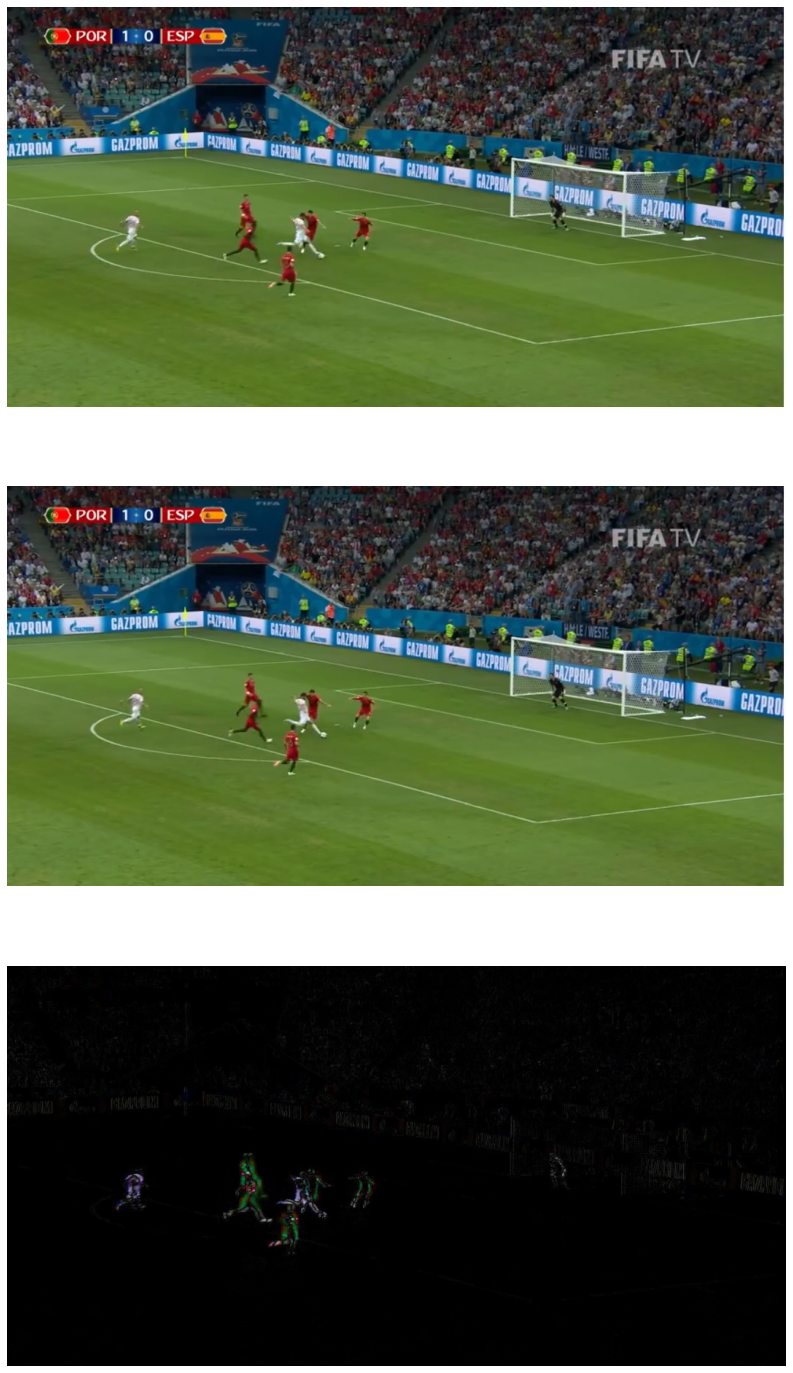

In [56]:
from PIL.ImageChops import subtract, multiply, screen, difference, add
im1 = Image.open(PATH + "goal1.png") # load two consecutive frame images from the video
im2 = Image.open(PATH + "goal2.png")
im = difference(im1, im2)
plt.figure(figsize=(20,25))
im.save(output_path_dir_w_time + "/goal_diff.png")
plt.subplot(311)
plt.imshow(im1)
plt.axis('off')
plt.subplot(312)
plt.imshow(im2)
plt.axis('off')
plt.subplot(313)
plt.imshow(im), plt.axis('off')
plt.show()

# Add noise / denoise

PSNR with Gaussian Blur: 31.390352632381973
PSNR with Non-Local Means Denoising: 31.091908866049927
PSNR with Bilateral Filter: 31.35944467240755


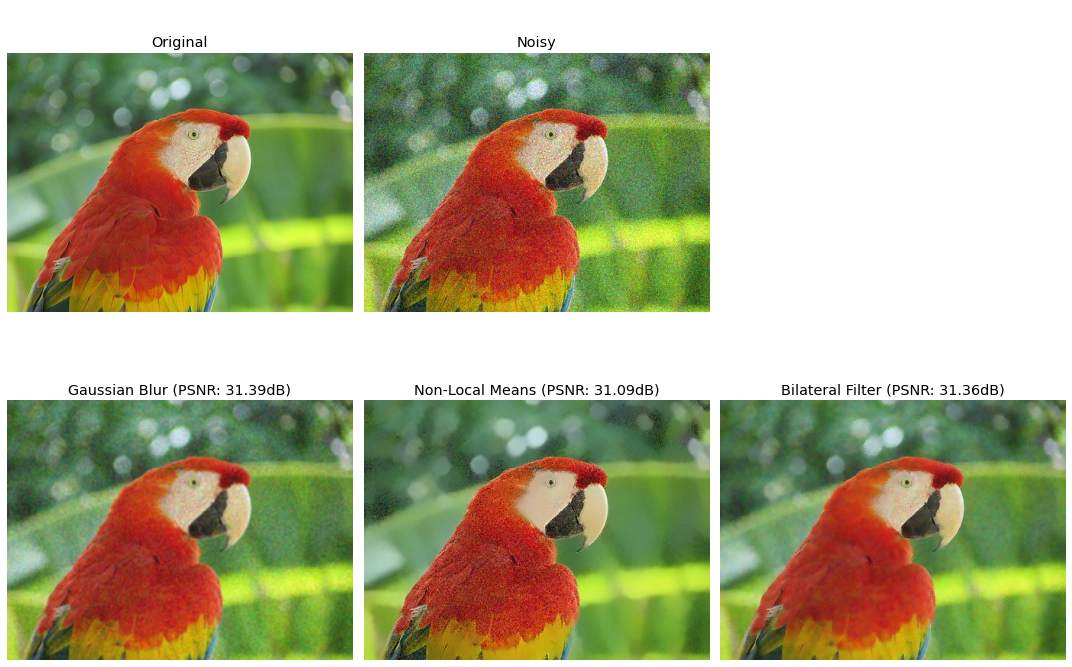

In [57]:
import cv2
import numpy as np

def add_noise(img, mean=0, std=25):
    """Add Gaussian noise to an image."""
    row, col, ch = img.shape
    gauss = np.random.normal(mean, std, (row, col, ch))
    noisy = np.clip(img + gauss, 0, 255)
    return noisy.astype('uint8')

def psnr(img1, img2):
    """Compute PSNR between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

# Add noise
noisy_img = add_noise(image_rgb)

# Apply Gaussian Blur
denoised_gb = cv2.GaussianBlur(noisy_img, (5, 5), 0)

# Apply Non-Local Means Denoising
denoised_nlm = cv2.fastNlMeansDenoisingColored(noisy_img, None, 10, 10, 7, 21)

# Apply Bilateral Filter
denoised_bf = cv2.bilateralFilter(noisy_img, 9, 75, 75)

# Calculate PSNR
psnr_gb = psnr(image_rgb, denoised_gb)
psnr_nlm = psnr(image_rgb, denoised_nlm)
psnr_bf = psnr(image_rgb, denoised_bf)

print(f"PSNR with Gaussian Blur: {psnr_gb}")
print(f"PSNR with Non-Local Means Denoising: {psnr_nlm}")
print(f"PSNR with Bilateral Filter: {psnr_bf}")

# Display images using matplotlib
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title('Original')
axes[0, 1].imshow(noisy_img)
axes[0, 1].set_title('Noisy')
axes[0, 2].axis('off')

axes[1, 0].imshow(denoised_gb)
axes[1, 0].set_title(f'Gaussian Blur (PSNR: {psnr_gb:.2f}dB)')
axes[1, 1].imshow(denoised_nlm)
axes[1, 1].set_title(f'Non-Local Means (PSNR: {psnr_nlm:.2f}dB)')
axes[1, 2].imshow(denoised_bf)
axes[1, 2].set_title(f'Bilateral Filter (PSNR: {psnr_bf:.2f}dB)')

for ax in axes.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()

# Questions

Q1) Use the scikit-image library's functions to read a collection of images and display them as a montage.

Q2) Use the scipy ndimage and misc modules' functions to zoom, crop, resize, and apply Affine transformation to an image.

Q3) Create a Python remake of the Gotham Instagram filter (hint: manipulate an image with the PIL split(), merge(), and numpy interp() functions to create a channel interpolation.

if you're stuck, here is some links:

1- https://github.com/lukexyz/CV-Instagram-Filters

2- https://www.practicepython.org/blog/2016/12/20/instagram-filters-python.html

3- https://www.youtube.com/watch?v=otLGDpBglEA